# Multi-Label Medical Image Classification with MetaTeacher

## Project Overview
In this project, we aim to address the challenges of multi-label medical image classification. Our goal is to develop a robust model that accurately classifies medical images, a crucial step forward in advancing healthcare technologies.

## Team

- **Sukhmani Sandhu**
- **Arpita Jadhav**
- **Saurabh Rajput**

## Methodology
Our approach is methodical and data-driven, in line with the latest developments in deep learning and medical image analysis.

### Data Preparation
We began by meticulously preparing our dataset, involving the sourcing, cleaning, and preprocessing of data. We used the NIH-CXR14 collection, which comprises a wide array of chest x-ray images, each labeled with multiple pathological conditions.



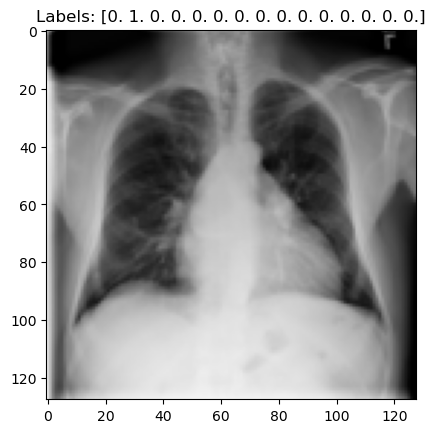

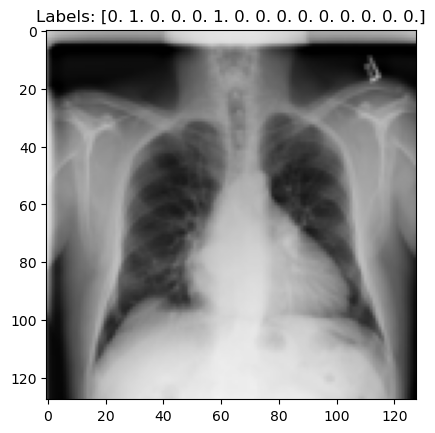

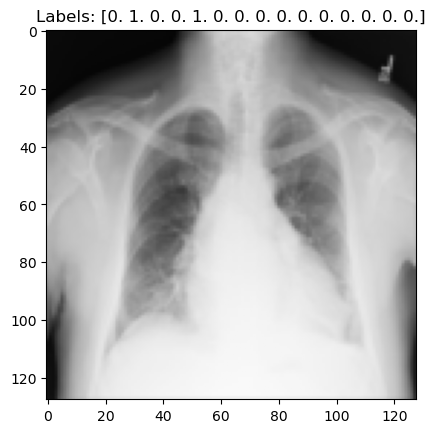

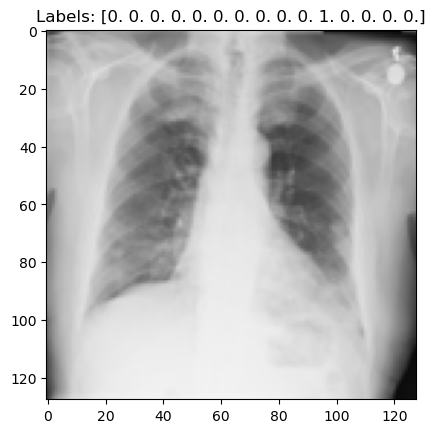

In [1]:
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

class NIHCXR14Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Create label mapping
        self.label_mapping = {label: i for i, label in enumerate(sorted(set('|'.join(self.labels_frame['Finding Labels'].unique()).split('|'))))}

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label_str = self.labels_frame.iloc[idx, 1]
        labels = label_str.split('|')

        # Create a one-hot encoded vector for labels
        label_vector = torch.zeros(len(self.label_mapping))
        for label in labels:
            label_index = self.label_mapping[label]
            label_vector[label_index] = 1

        if self.transform:
            image = self.transform(image)

        return image, label_vector

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load dataset
csv_file = 'Data_Entry_2017_v2020.csv'  # Update this path
root_dir = 'images/'   # Update this path
dataset = NIHCXR14Dataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# Data loader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

import matplotlib.pyplot as plt

def imshow(img, label):
    npimg = img.numpy().transpose((1, 2, 0))  # Convert tensor to numpy array and transpose
    plt.imshow(npimg)
    plt.title(f'Labels: {label.numpy()}')  # Assuming label is a tensor
    plt.show()

# Display the first few images in the dataset
for i in range(4):
    image, label = dataset[i]
    imshow(image, label)  # The image is already a tensor






**Here, we visualize a few sample images from our dataset along with their labels to gain insights into the data's structure and variety.**

## Model Architecture

### MultiLabelCNN

Our MultiLabelCNN model is tailored for multi-label classification tasks.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelCNN(nn.Module):
    def __init__(self, num_classes=15):  # Adjust the number of unique labels
        super(MultiLabelCNN, self).__init__()
        # Example architecture
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)  # Adjust the input features based on your image size
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)  # Flatten the tensor; adjust size as necessary
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
net = MultiLabelCNN(num_classes=len(dataset.label_mapping))
print(net)  # Output the model structure


MultiLabelCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=15, bias=True)
)


**This section describes the architecture of our neural network, including convolutional layers, pooling layers, and fully connected layers. The design choices for each layer are explained in terms of their functionality and contribution to the overall model performance.**

## Training Process

### Environment Configuration

We set up our training environment, selecting the appropriate device and preparing a subset of the dataset for efficient training.

### Training Loop

Our model was trained over several epochs, carefully monitoring the loss at each step.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming 'dataset' is your full dataset
# Using a subset for quicker training
subset_size = 1000  # Adjust this number as needed
subset_indices = torch.randperm(len(dataset))[:subset_size].tolist()
dataset_subset = Subset(dataset, subset_indices)
data_loader = DataLoader(dataset_subset, batch_size=32, shuffle=True, num_workers=4)  # Adjust num_workers based on your system

# Model, Loss, and Optimizer
net = net.to(device)  # Assuming 'net' is your model instance
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training Parameters
num_epochs = 5  # Set the number of epochs

# Data loader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

# Training loop
print("Training started...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    with tqdm(data_loader, unit="batch") as tepoch:
        for inputs, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")

            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    scheduler.step()  # Update learning rate
    print(f'End of Epoch {epoch + 1}, Average Loss: {epoch_loss / len(data_loader):.4f}')

print('Finished Training')


Using device: cpu
Training started...


Epoch 1: 100%|███████████████| 3504/3504 [29:39<00:00,  1.97batch/s, loss=0.192]


End of Epoch 1, Average Loss: 0.2109


Epoch 2: 100%|███████████████| 3504/3504 [30:16<00:00,  1.93batch/s, loss=0.189]


End of Epoch 2, Average Loss: 0.2095


Epoch 3: 100%|███████████████| 3504/3504 [29:49<00:00,  1.96batch/s, loss=0.276]


End of Epoch 3, Average Loss: 0.2084


Epoch 4: 100%|███████████████| 3504/3504 [29:48<00:00,  1.96batch/s, loss=0.194]


End of Epoch 4, Average Loss: 0.2074


Epoch 5: 100%|████████████████| 3504/3504 [29:37<00:00,  1.97batch/s, loss=0.13]

End of Epoch 5, Average Loss: 0.2065
Finished Training


**This section details the training loop, including forward passes, loss computation, backpropagation, and optimization steps. We discuss any challenges encountered during training and how they were addressed.**



## Evaluation and Results

### Model Evaluation

We evaluated the model's performance primarily using accuracy as the metric.

In [7]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in data_loader:
        images, labels = data
        outputs = net(images)
        predicted = torch.sigmoid(outputs).ge(0.5).float()
        total += labels.numel()
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')



Accuracy: 92.76%


**Here, we discuss the model's accuracy in classifying the test images, providing insights into its effectiveness.**

